In [35]:
import numpy as np
import pyaudio
import matplotlib.pyplot as plt
from pynput import keyboard
import struct
import math
import scipy.signal
import time
import datetime
import itertools
from collections import deque

global p
global stream

# Guitar - MIDDLE C (C4) IS 2nd String 1st Fret!!!! (NOT 5th string 3rd fret)
NOTE_MIN = 36       # E2 = 40
NOTE_MAX = 80       # E5 = 76

FSAMP = 44100       # Sampling frequency in Hz # 22050 or 44100?
FRAME_SIZE = 8192   # How many samples per frame? increasing this increases accuracy, but makes it harder to pick up quick notes
FRAMES_PER_FFT = 1 # FFT takes average across how many frames?

SAMPLES_PER_FFT = FRAME_SIZE*FRAMES_PER_FFT
FREQ_STEP = float(FSAMP)/SAMPLES_PER_FFT

NOTE_NAMES = 'C C# D D# E F F# G G# A A# B'.split()

# For tap recognition
SHORT_NORMALIZE = (1.0/32768.0)


def freq_to_number(f): return 69 + 12*np.log2(f/440.0)
def number_to_freq(n): return 440 * 2.0**((n-69)/12.0)
def note_name(n): return NOTE_NAMES[n % 12] + str(round(n/12 - 1))

# Get min/max index within FFT of notes we care about.
# See docs for numpy.rfftfreq()
def note_to_fftbin(n): return number_to_freq(n)/FREQ_STEP


In [10]:
def on_press(key):
    if key == keyboard.Key.esc:
        return False  # stop listener
    try:
        k = key.char  # single-char keys
    except:
        k = key.name  # other keys
    if k == "enter":
        stream.stop_stream()
        return False  # stop listener; remove this if want more keys
    
def get_rms( block ):
    # RMS amplitude is defined as the square root of the 
    # mean over time of the square of the amplitude.
    # so we need to convert this string of bytes into 
    # a string of 16-bit samples...

    # we will get one short out for each 
    # two chars in the string.
    count = len(block)/2
    format = "%dh"%(count)
    shorts = struct.unpack( format, block )

    # iterate over the block.
    sum_squares = 0.0
    for sample in shorts:
        # sample is a signed short in +/- 32768. 
        # normalize it to 1.0
        n = sample * SHORT_NORMALIZE
        sum_squares += n*n

    return math.sqrt( sum_squares / count )

def autopower_spectrum(samples, window):
    windowed = samples * window
    # Add 0s to double the length of the data
    padded = np.append(windowed, np.zeros(SAMPLES_PER_FFT))
    # Take the Fourier Transform and scale by the number of samples
    spectrum = np.fft.fft(padded) / SAMPLES_PER_FFT
    autopower = np.abs(spectrum * np.conj(spectrum))
    return autopower[:SAMPLES_PER_FFT]



In [ ]:
# Some references
https://medium.com/@ianvonseggern/note-recognition-in-python-c2020d0dae24
https://stackoverflow.com/questions/1303307/fft-for-spectrograms-in-python
https://stackoverflow.com/questions/4160175/detect-tap-with-pyaudio-from-live-mic
https://github.com/aniawsz/rtmonoaudio2midi
https://makersportal.com/blog/2018/9/20/audio-processing-in-python-part-iii-guitar-string-theory-and-frequency-analysis

In [36]:
imin = max(0, int(np.floor(note_to_fftbin(NOTE_MIN-1))))
imax = min(SAMPLES_PER_FFT, int(np.ceil(note_to_fftbin(NOTE_MAX+1))))
print(imin)
print("Frequency Range:")
print(imin*FREQ_STEP)
print(imax*FREQ_STEP)


11
Frequency Range:
59.21630859375
882.861328125


In [40]:
listener = keyboard.Listener(on_press=on_press)
listener.start()  # start to listen on a separate thread
#listener.join()  # remove if main thread is polling self.keys

imin = max(0, int(np.floor(note_to_fftbin(NOTE_MIN-1))))
imax = min(SAMPLES_PER_FFT, int(np.ceil(note_to_fftbin(NOTE_MAX+1))))
print("Frequency Range:")
print(imin*FREQ_STEP)
print(imax*FREQ_STEP)

print("Get Ready")
time.sleep(3)
print("Go!")

# Allocate space to run an FFT. 
buf = np.zeros(SAMPLES_PER_FFT, dtype=np.float32)
num_frames = 0

# Initialize audio
stream = pyaudio.PyAudio().open(format=pyaudio.paInt16,
                                channels=1,
                                rate=FSAMP,
                                input=True,
                                frames_per_buffer=FRAME_SIZE)

stream.start_stream()
# Create Hanning window function
window = 0.5 * (1 - np.cos(np.linspace(0, 2*np.pi, SAMPLES_PER_FFT, False)))

# Print initial text
print ('sampling at', FSAMP, 'Hz with max resolution of', FREQ_STEP, 'Hz')

#Previous data
prevNote = ""
last_spectrum = np.zeros(SAMPLES_PER_FFT, dtype=np.int16)
last_flux = deque(
            np.zeros(int(FREQ_STEP), dtype=np.int16), int(FREQ_STEP))
last_prunned_flux = 0
first_peak = True

vals=np.array([])
amps = []
main_notes = []
all_notes = []

# As long as we are getting data:

t1 = datetime.datetime.now()
while stream.is_active():
    # Shift the buffer down and new data in
    buf[:-FRAME_SIZE] = buf[FRAME_SIZE:] # old data moves to front
    buf[-FRAME_SIZE:] = np.frombuffer(stream.read(FRAME_SIZE), np.int16)
    vals = np.concatenate((vals, buf[-FRAME_SIZE:]), axis = None) # Array of ALL raw data
    
    # Get amplitude of raw data -- not really reliable tbh
    amp = get_rms(stream.read(FRAME_SIZE))
    amps.append(amp)    
    
    # DETECT NEW NOTE
    spectrum = autopower_spectrum(buf, window)

    flux = sum([max(spectrum[n] - last_spectrum[n], 0)
        for n in range(SAMPLES_PER_FFT)])
    last_flux.append(flux)
    # adjust thresholding 
    flux_for_thresholding = list(itertools.islice(
            last_flux,
            int(FREQ_STEP) - 3,
            int(FREQ_STEP)))
    thresholded = np.mean(flux_for_thresholding) * 2
    #print(flux)
    #print(thresholded)
    prunned = flux - thresholded if thresholded <= flux else 0
    peak = prunned if prunned > last_prunned_flux else 0
    last_prunned_flux  = prunned
    last_spectrum = spectrum
    
    
    
    # FFT TO OBTAIN FREQUENCY RESPONSE
    # TODO: Volume check to avoid picking up noise -- look at amplitude of FFT?
    # Run the FFT on the windowed buffer
    fft = np.fft.rfft(buf * window)
    fft = np.abs(fft[imin:imax])
    # Normalize response -- this is for identifying the most prominent notes in the response... 
    # Loses info on amplitude (we only have relative amplitude)
    fft_norm = np.true_divide(fft, max(fft))
    # Apply median filter
    orig_resp = np.abs(fft)
    orig_filtered_response = scipy.signal.medfilt(orig_resp,1)
    freq_resp = np.abs(fft_norm)
    filtered_response = scipy.signal.medfilt(freq_resp,1)
    
    
    
    # FREQUENCIES
    freq_peaks_index = scipy.signal.find_peaks(filtered_response, height = 0.6)[0] 
    freqs = [(i+imin)*FREQ_STEP for i  in freq_peaks_index]
    # Get frequency of maximum response in range
    max_freq = (np.abs(orig_filtered_response).argmax() + imin) * FREQ_STEP

    
    
    
    # NOTES
    # Get note number and nearest note
    n = freq_to_number(max_freq)
    n0 = int(round(n)) # loudest note
    cn = [note_name(int(round(freq_to_number(f)))) for f in freqs] # all notes above threshold
    currNote = note_name(n0)
    
    # Console output once we have a full buffer
    num_frames += 1
    if num_frames >= FRAMES_PER_FFT:
        t2=datetime.datetime.now()
        if num_frames < 5:
            print("TIME: ", t2-t1)
        if peak and amp > 0.05:
        
            main_notes.append(note_name(n0)) 
            all_notes.extend(cn)
            print ('freq: {:7.2f} Hz     note: {:>3s} {:+.2f}'.format(
                max_freq, note_name(n0), n-n0))
            print(cn)
            print("AMPLITUDE: ", amp)
            
            """
            plt.figure()
            fig, (ax1, ax2) = plt.subplots(1, 2)
            ax1.plot(filtered_response)
            ax2.plot(orig_filtered_response)
            plt.show()
            """
            
            my_data = np.frombuffer(stream.read(FRAME_SIZE), np.int16)
    prevNote = currNote
    if((t2-t1) >  datetime.timedelta(0,15)):
        stream.stop_stream()
stream.close() 
print("CLOSING...")
print(main_notes)
print(all_notes)

Frequency Range:
59.21630859375
882.861328125
Get Ready
Go!
sampling at 44100 Hz with max resolution of 5.38330078125 Hz
TIME:  0:00:00.381830
TIME:  0:00:00.751409
TIME:  0:00:01.120396
TIME:  0:00:01.490194
freq:  193.80 Hz     note:  G4 -0.20
['G4']
AMPLITUDE:  0.25852977545498657
freq:  220.72 Hz     note:  A4 +0.06
['A4', 'B4']
AMPLITUDE:  0.059841920211975784
freq:  145.35 Hz     note:  D3 -0.18
['D3', 'B4', 'G5']
AMPLITUDE:  0.30671444824874106
CLOSING...
['G4', 'A4', 'D3']
['G4', 'A4', 'B4', 'D3', 'B4', 'G5']


In [15]:
print(len(my_data))
print(len(buf))

2048
32768


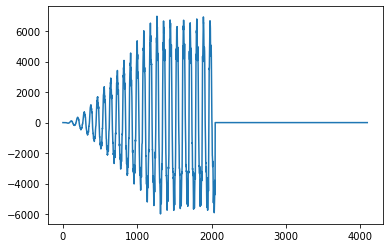

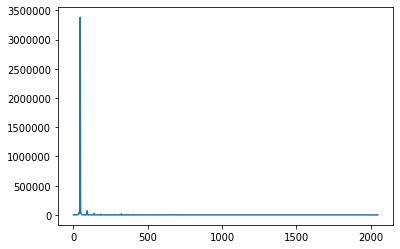

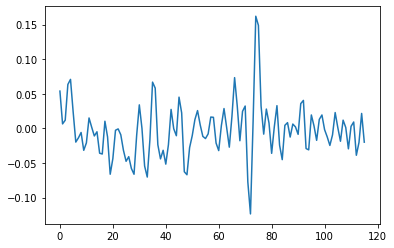

250.5681818181818


In [49]:
# METHOD 2
d2 = np.append(my_data, np.zeros(2048))
windowed = d2 * window
# Add 0s to double the length of the data
padded = windowed
plt.plot(padded)

#padded = np.append(windowed, np.zeros(2048))
# Take the Fourier Transform and scale by the number of samples
spectrum = np.fft.fft(padded) / 2048
autopower = np.abs(spectrum * np.conj(spectrum))
plt.figure()
plt.plot(autopower[:2048])


spec = np.fft.fft(my_data)
log_spec = np.log(np.abs(spec))
cepstrum = np.fft.ifft(log_spec).real
plt.figure()
plt.plot(cepstrum[imin:imax])
plt.show()
print(FSAMP/(imin + cepstrum[imin:imax].argmax()))

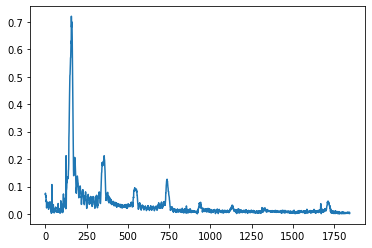

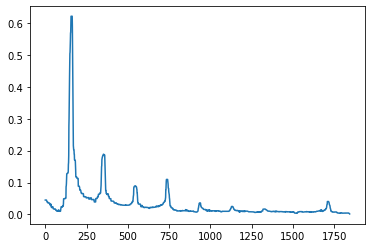

[262.4359130859375]
['C4']


In [26]:
freq_resp = np.abs(my_fft[imin:imax])*FREQ_STEP
med_filt= scipy.signal.medfilt(freq_resp,15)
plt.figure()
plt.plot(freq_resp)
plt.figure()
plt.plot(med_filt)
plt.show()


freq_peaks_index = scipy.signal.find_peaks(med_filt, height = 0.3)[0]
freqs = [(i+imin)*FREQ_STEP for i  in freq_peaks_index]
print(freqs)

cn = [note_name(int(round(freq_to_number(f)))) for f in freqs]

print(cn)

['C4']
[1.4650622840630737e-05, 0.0003869902974495463, 0.005946890366198517, 0.008053713934333096, 0.007660977676070241, 0.0069824851421260905, 0.007434649211670752, 0.006897967797408795, 0.0064581976224234285, 0.0064661139552287675, 0.007206640620616479, 0.27700677683361946, 0.3073027682481299, 0.2865500701110171, 0.2730067820027293, 0.19381175934490205, 0.1611392987969396, 0.1439129531487483, 0.10318673398819925, 0.10190531743182013, 0.10726670652364212, 0.08320759028750027, 0.06024366282613983, 0.01110064211097718, 0.0053097670710769785, 0.0038621739343791066, 0.0038165807246652492, 0.00386061098020285, 0.0027925644828489696, 0.002622102862871753, 0.002869914939304655, 0.001996371232231421, 0.001747969776023675, 0.001953275519211178, 0.0015904362841892062, 0.0010737170055511599, 0.0007117487443970425, 0.0007774434683523465, 0.00128888634015144, 0.0011024147164110415]


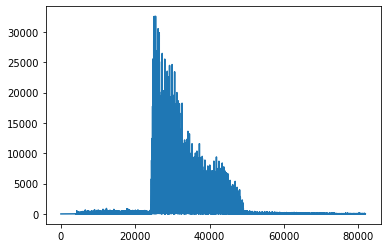

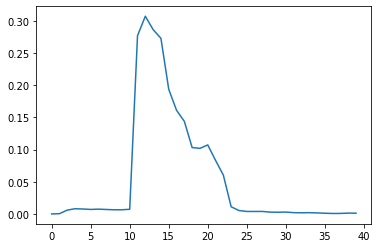

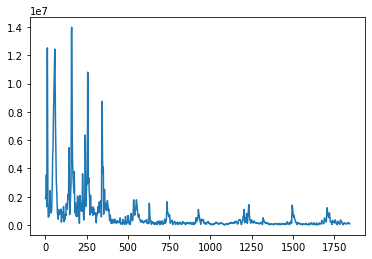

In [6]:
print(notes)
plt.plot(abs(vals))
print(amps)
plt.figure()
plt.plot(amps)
plt.figure()
plt.plot(np.abs(my_fft[imin:imax])*FREQ_STEP)
plt.show()
